In [1]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def visualize_mesh(pos, face):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

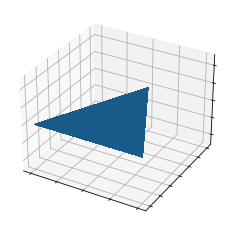

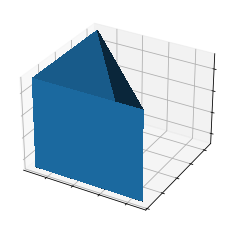

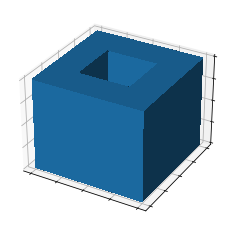

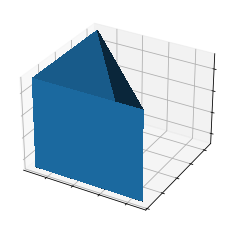

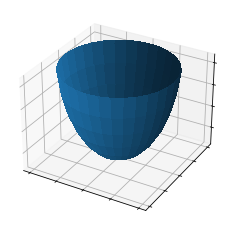

In [3]:
from torch_geometric.datasets import GeometricShapes
import numpy as np
dataset = GeometricShapes(root="../datasets/GeometricShapes")
sample_idx = np.random.randint(0, len(dataset), size=5)
for idx in sample_idx:
    data = dataset[idx]
    visualize_mesh(data.pos, data.face)

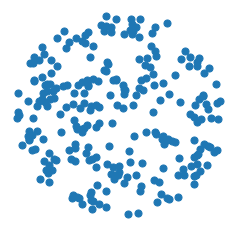

In [4]:
from torch_geometric.transforms import SamplePoints

dataset.transform = SamplePoints(num=256)
data = dataset[0]
visualize_points(data.pos, data.edge_index)

In [12]:
data.edge_index

torch.Size([2, 1536])


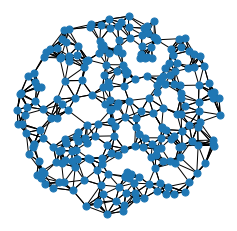

In [5]:
from torch_cluster import knn_graph
data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

In [6]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="max")
        self.mlp = Sequential(
            Linear(in_channels + 3, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        input = pos_j - pos_i
        if h_j is not None:
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)

In [7]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import GCNConv

class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self, pos, batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)

        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = F.relu(h)
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = F.relu(h)

        h = global_max_pool(h, batch)
        return self.classifier(h)


model = PointNet()
model

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)

In [8]:
from torch_geometric.loader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = GeometricShapes(root="../datasets/GeometricShapes", train=True, transform=SamplePoints(128))
test_dataset = GeometricShapes(root="../datasets/GeometricShapes", train=False, transform=SamplePoints(128))

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PointNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        logits = model(data.pos, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(model, loader):
    model.eval()
    total_correct = 0
    for data in loader:
        data = data.to(device)
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 101):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch: 10, Loss: 3.2500, Test Accuracy: 0.0500
Epoch: 20, Loss: 2.0449, Test Accuracy: 0.4750
Epoch: 30, Loss: 0.9496, Test Accuracy: 0.6250
Epoch: 40, Loss: 0.9373, Test Accuracy: 0.7000
Epoch: 50, Loss: 1.8558, Test Accuracy: 0.7500
Epoch: 60, Loss: 0.5556, Test Accuracy: 0.8250
Epoch: 70, Loss: 0.3940, Test Accuracy: 0.8750
Epoch: 80, Loss: 0.2235, Test Accuracy: 0.9250
Epoch: 90, Loss: 0.4466, Test Accuracy: 0.8500
Epoch: 100, Loss: 0.1351, Test Accuracy: 0.9500


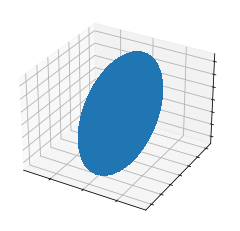

In [9]:
from torch_geometric.transforms import Compose, RandomRotate
random_rotate = Compose([
    RandomRotate(degrees=180, axis=0),
    RandomRotate(degrees=180, axis=1),
    RandomRotate(degrees=180, axis=2),
])

dataset = GeometricShapes(root="../datasets/GeometricShapes", transform=random_rotate)

data = dataset[0]
visualize_mesh(data.pos, data.face)

In [10]:
transform = Compose([random_rotate, SamplePoints(num=128)])

test_dataset = GeometricShapes(root="../datasets/GeometricShapes", train=False, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=10)
test_acc = test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.1750
